# POC-Turtle word category learner, part 3. Disjuncts.
This is a continuation of parts 1 and 2 of proof-of-concept (POC) experiments in unsupervised language learning (ULL). 
The previous notebooks re available as static html pages 
([1](http://88.99.210.144/data/clustering_2018/html/POC-Turtle-1-2018-02-09.html) 
and [2](http://88.99.210.144/data/clustering_2018/html/POC-Turtle-2-Singular-Values)), 
code hosted on [GitHub](https://github.com/opencog/language-learning)

This time we check the possibility of unsupervised word category learning using "disjucts" - pairs of links to the heighbouring words.

In [1]:
import os, sys, time, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path: sys.path.append(module_path)
from src.utl.utl import UTC
from src.space.turtle import dumb_disjuncter
from src.space.sws import word_space
from src.space.hyperwords import epmisvd
from src.utl.turtle import html_table, plot2d
from src.clustering.kmeans import cluster_kmeans
from src.clustering.similarity import cosine_similarity
print(UTC(), ':: module_path:', module_path)

2018-02-17 16:49:29 UTC :: module_path: /home/oleg/language-learning


## 3.1 Settings
We use the same simplified "Turtle language" corpus:

In [2]:
input_file = '../data/poc-turtle-sentences.txt'
with open(input_file, 'r') as f: lines = f.read().splitlines()
for line in lines: print(line)

tuna isa fish.
herring isa fish.
tuna has fin.
herring has fin.
parrot isa bird.
eagle isa bird.
parrot has wing.
eagle has wing.
fin isa extremity.
wing isa extremity.
fin has scale.
wing has feather.



In [3]:
prj_dir = '../output/Turtle-3-2018-02-17/'  # project directory 
prefix = ''     # all project files will start with this prefix
verbose = 'max' # printed comments: 'none', 'min', 'max'
log = {'project': 'POC-Turtle-3 v.3.2'}

if not os.path.isfile(input_file):
    print('No data file', module_path + input_file[2:])
else: print('Data file found:', module_path + input_file[2:])
if not os.path.exists(prj_dir):
    os.makedirs(prj_dir)
    print('Project directory created:', module_path + prj_dir[2:])
else: print('Project directory', module_path + prj_dir[2:], 'exists')
if verbose == 'max': print(UTC(), log)
log.update({'input_file': module_path + input_file[2:]})

Data file found: /home/oleg/language-learning/data/poc-turtle-sentences.txt
Project directory /home/oleg/language-learning/output/Turtle-3-2018-02-17/ exists
2018-02-17 16:49:29 UTC {'project': 'POC-Turtle-3 v.3.2'}


## 3.2 Parse sentences to disjuncts

In [4]:
left_wall = '#LW#'  # Left wall symbol, 'none' - don't use Left-Wall
disjuncts = dumb_disjuncter(input_file, left_wall, dot=True,)
if verbose != 'none': print('disjuncts:', type(disjuncts), len(disjuncts), 'items') 
disjuncts = disjuncts.groupby(['word','disjunct'], as_index=False).sum() \
    .sort_values(by=['count','word','disjunct'], ascending=[False,True,True]) \
    .reset_index(drop=True)
#disjuncts
if verbose == 'max': 
    with pd.option_context('display.max_rows', 8): print(disjuncts, '\n')

disjuncts: <class 'pandas.core.frame.DataFrame'> 60 items
    word   disjunct  count
0   #LW#     eagle+      2
1   #LW#       fin+      2
2   #LW#   herring+      2
3   #LW#    parrot+      2
..   ...        ...    ...
40  tuna  #LW#-has+      1
41  tuna  #LW#-isa+      1
42  wing  #LW#-has+      1
43  wing  #LW#-isa+      1

[44 rows x 3 columns] 



## 3.3 Create word vector space

In [5]:
path = module_path + prj_dir[2:]    # path to vectors
tmpath = path  # tmpath = module_path + '/tmp/'  # path for temporary files 
disjuncts = disjuncts.rename(columns={'disjunct':'link'})
words, context, res1 = word_space(disjuncts, path, '', verbose='none')
dim = 12    # Vector space dimensions
vdf, res2 = epmisvd(disjuncts, path, tmpath, dim)
if len(vdf.columns) < dim+1:
    print('Vector space dimensionality: suggested', str(dim)+',', \
          'maximum created with SVM algorithm:', len(vdf.columns)-1)
zdf = vdf.copy()
cols = zdf.columns.tolist()
del zdf['word']
def zeros(x):
    if abs(x) > 1e-10: return round(x,5)
    else: return 0
zdf = zdf.applymap(zeros)
zdf['word'] = vdf['word']
zdf = zdf[cols]
zdf.sort_values(by=[1,2], ascending=[True,True])

Vector space dimensionality: suggested 12, maximum created with SVM algorithm: 9


,word,1,2,3,4,5,6,7,8,9
10,isa,-0.91630,0.40049,0.00000,0.0,0.0,0,-0.0,0.00000,0.00000
8,has,-0.40049,-0.91630,0.00000,0.0,0.0,0,0.0,0.00000,0.00000
0,#LW#,0.00000,0.00000,0.00000,0.0,0.0,0,1.0,0.00000,0.00000
1,.,0.00000,0.00000,0.00000,1.0,0.0,0,0.0,0.00000,0.00000
2,bird,0.00000,0.00000,0.00000,0.0,1.0,0,0.0,0.00000,0.00000
3,eagle,0.00000,0.00000,0.90007,0.0,0.0,0,-0.0,-0.43575,0.00003
4,extremity,0.00000,0.00000,0.00000,0.0,1.0,0,0.0,0.00000,0.00000
5,feather,0.00000,0.00000,0.33635,0.0,0.0,0,-0.0,0.94174,0.00005
6,fin,0.00000,0.00000,0.84445,0.0,0.0,0,0.0,0.53563,-0.00010
7,fish,0.00000,0.00000,0.00000,0.0,1.0,0,0.0,0.00000,0.00000


### 3.3.1 Check vector space singular values

Singular values: 5.64, 5.64, 5.08, 4.26, 3.99, 0.0, 3.94, 3.75, 0.0


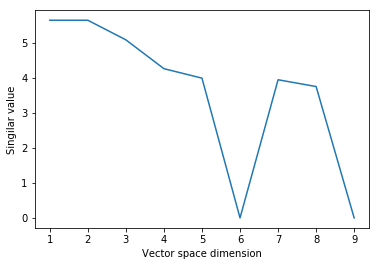

In [6]:
singular_values = pd.DataFrame(np.load(path+'svd.s.npy'),columns=['sv'])
singular_values.index = range(1,len(singular_values)+1)
print('Singular values:', \
      ', '.join(str(round(x,2)) for x in singular_values['sv']))
singular_values
plt.plot(singular_values.index, singular_values['sv'])
plt.xlabel('Vector space dimension')
plt.ylabel('Singilar value')
plt.show()

WOW! Looks awkward...

### 3.3.2 Remove zero dimensions

In [7]:
zdf.drop(zdf.columns[[6,9]],axis=1,inplace=True)
zdf.sort_values(by=[1,2], ascending=[True,True])

,word,1,2,3,4,5,7,8
10,isa,-0.91630,0.40049,0.00000,0.0,0.0,-0.0,0.00000
8,has,-0.40049,-0.91630,0.00000,0.0,0.0,0.0,0.00000
0,#LW#,0.00000,0.00000,0.00000,0.0,0.0,1.0,0.00000
1,.,0.00000,0.00000,0.00000,1.0,0.0,0.0,0.00000
2,bird,0.00000,0.00000,0.00000,0.0,1.0,0.0,0.00000
3,eagle,0.00000,0.00000,0.90007,0.0,0.0,-0.0,-0.43575
4,extremity,0.00000,0.00000,0.00000,0.0,1.0,0.0,0.00000
5,feather,0.00000,0.00000,0.33635,0.0,0.0,-0.0,0.94174
6,fin,0.00000,0.00000,0.84445,0.0,0.0,0.0,0.53563
7,fish,0.00000,0.00000,0.00000,0.0,1.0,0.0,0.00000


## 3.4 Clustering
### 3.4.1 Find optimal number of clusters

Silhouette index in a range of cluster numbers


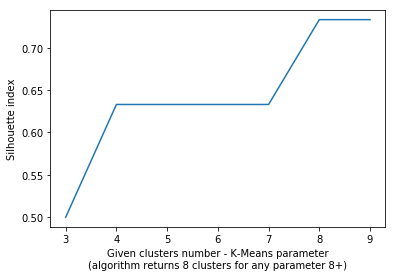

N,NR,Silhouette,Clusters
3,3,0.5,eagle herring parrot tuna | #LW# . bird extremity fish has isa | feather fin scale wing
4,4,0.633,feather fin scale wing | eagle herring parrot tuna | #LW# . has isa | bird extremity fish
5,5,0.633,bird extremity fish | eagle herring parrot tuna | . | feather fin scale wing | #LW# has isa
6,6,0.633,feather fin scale wing | eagle herring parrot tuna | bird extremity fish | . | has isa | #LW#
7,7,0.633,bird extremity fish | eagle herring parrot tuna | feather fin scale wing | . | #LW# | has | isa
8,8,0.733,fin wing | bird extremity fish | eagle herring parrot tuna | isa | #LW# | . | has | feather scale
9,8,0.733,. | has | fin wing | bird extremity fish | eagle herring parrot tuna | #LW# | isa | feather scale


In [8]:
words = vdf['word'].tolist()
df = zdf.copy()
del df['word']
sil_range = pd.DataFrame(columns=['NC','NR','Silhouette','Inertia'])
sil_range['NC'] = sil_range['NC'].astype(int)
table = [['N', 'NR', 'Silhouette', 'Clusters']]
tsv = 'N\tNR\tSilhouette\tClusers\n'
for i,j in enumerate(range(3,10)):
    silhouette, inertia, cluster_labels, centroids, cluster_sizes, \
        cluster_word_ids, cluster_words = cluster_kmeans(j, df, words)
    sil_range.loc[i] = [j, len(cluster_words), round(silhouette,3), inertia]
    table.append([j, len(cluster_words), round(silhouette,3), \
        ' | '.join(' '.join(str(word) for word in cluster)
            .replace('###LEFT-WALL###', '#LW#') for cluster in cluster_words)])
    tsv = tsv + str(j) + '\t' + str(len(cluster_words)) + '\t' + \
        str(round(silhouette,3)) + '\t' + \
        ' '.join('|'.join(str(word) for word in cluster) \
                 for cluster in cluster_words) + '\n'
sil_range[['NC','NR']] = sil_range[['NC','NR']].astype(int)

print('Silhouette index in a range of cluster numbers')
plt.plot(sil_range['NC'], sil_range['Silhouette'])
plt.xlabel('Given clusters number - K-Means parameter\n' + \
           '(algorithm returns 8 clusters for any parameter 8+)')
plt.ylabel('Silhouette index')
plt.show()
display(html_table(table))

The Silhouette index suggests 8 clusters...
However 6 looks looks pretty good...

### 3.4.2 Cluster words

In [9]:
n = 8  # Optimal number of clusters defined by max silhouette index
words = vdf['word'].tolist()
silhouette, inertia, cluster_labels, centroids, cluster_sizes, \
    cluster_word_ids, cluster_words = cluster_kmeans(n, df, words)
cdf = pd.DataFrame(centroids)
def row_index(row): return int(row.name)
def cluster_word_list(row): return cluster_words[int(row.name)]
cls = cdf.applymap(zeros)
cls['cluster_words'] = cls.apply(cluster_word_list, axis=1)
cls.index = range(1,len(cls)+1)
cls['cluster'] = cls.apply(row_index, axis=1)
for col in cls.columns:
    if type(col) == int: cls=cls.rename(columns={col:col+11})
for col in cls.columns:
    if type(col) == int: cls=cls.rename(columns={col:col-10})
cls

,1,2,3,4,5,6,7,cluster_words,cluster
1,-0.91630,0.40049,0.00000,0.0,0.0,0.0,0.00000,[isa],1
2,0.00000,0.00000,0.84445,0.0,0.0,0.0,0.53563,"[fin, wing]",2
3,0.00000,0.00000,0.00000,0.0,1.0,0.0,0.00000,"[bird, extremity, fish]",3
4,0.00000,0.00000,0.90007,0.0,0.0,0.0,-0.43575,"[eagle, herring, parrot, tuna]",4
5,0.00000,0.00000,0.00000,1.0,0.0,0.0,0.00000,[.],5
6,0.00000,0.00000,0.00000,0.0,0.0,1.0,0.00000,[#LW#],6
7,-0.40049,-0.91630,0.00000,0.0,0.0,0.0,0.00000,[has],7
8,0.00000,0.00000,0.33635,0.0,0.0,0.0,0.94174,"[feather, scale]",8


### 3.4.3 Word clusters in 2D, axis 1 and 3
We have an awkward situation: the only two verbs have non-zero values for **both** axes 1 and 2.  
So to have an idea of word cluster spacial distribution we use the two axes with maximum non-zero values - 1 and 3.

Cluster words in vector space, axes 1 and 3


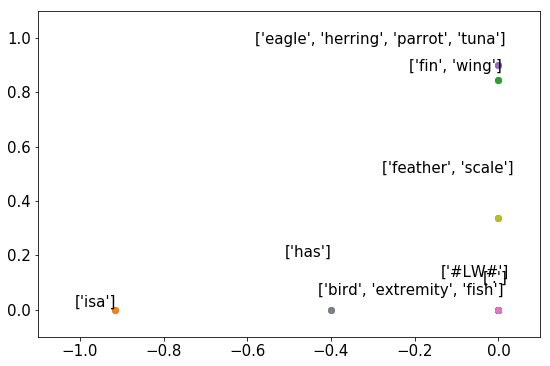

In [10]:
plot2d(1, 3, cls, 'cluster_words', 15)

## 3.5 Learn word categories from cluster similarities

Cluster similarities: absolute values > 1e-10:


,c1,c2,similarity,c1_words,c2_words
12,1,7,0.788455,"[fin, wing]","[feather, scale]"
8,1,3,0.526664,"[fin, wing]","[eagle, herring, parrot, tuna]"
21,3,7,-0.107624,"[eagle, herring, parrot, tuna]","[feather, scale]"


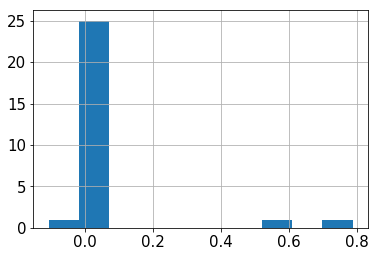

In [11]:
sim_df, res3 = cosine_similarity(centroids, cluster_words, 'max')
count, division = np.histogram(sim_df['similarity'])
sim_df['similarity'].hist(bins=division)
print('Cluster similarities: absolute values > 1e-10:')
sim_df.sort_values(by='similarity', ascending=False) \
      .loc[abs(sim_df['similarity']) > 1e-10]

Looks like we have got a problem: due to a specific words distribution in the word vector space we can't find similarity between words that have no common axes...  
**But** why we can't find similarity between the verbs (**has** and **isa**), both non-zero on axes 1 and 2?

### Trying to somehow cluster the verbs...

Cluster words in vector space, axes 1 and 2


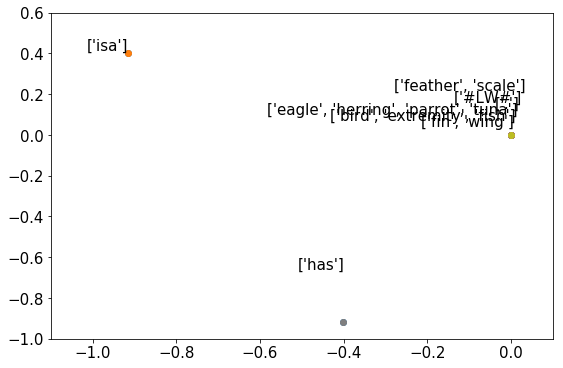

In [12]:
plot2d(1, 2, cls, 'cluster_words', 15)

In [13]:
verbs = list()
verb_vectors = list()
for i,centroid in enumerate(centroids):
    if abs(centroid[0]) > 1e-10:
        verbs.append(cluster_words[i])
        verb_vectors.append([centroid[0],centroid[1]])
print(verbs, verb_vectors)

[['isa'], ['has']] [[-0.9163, 0.40049], [-0.40049, -0.9163]]


Verb cluster similarities:


,c1,c2,similarity,c1_words,c2_words
0,0,1,0.0,[isa],[has]


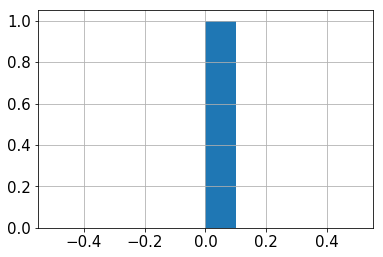

In [14]:
sim_df, res4 = cosine_similarity(verb_vectors, verbs, 'max')
count, division = np.histogram(sim_df['similarity'])
sim_df['similarity'].hist(bins=division)
print('Verb cluster similarities:')
sim_df.sort_values(by='similarity', ascending=False)

## 3.6 Resume: 
This time we failed to learn word categories by clustering disjuncts.  
But it's not final: we had very small dataset with frequency = 1 for most disjuncts.  
Therefore the word vector space [6] was rather specific and clustered in an awkward way [10]. 

## Appendix: No sentence borders?
Remove #Left-Wall# and period!

In [15]:
left_wall = 'none'  # Left wall symbol, 'none' - don't use left wall
disjuncts = dumb_disjuncter(input_file, left_wall, dot=False,)
if verbose != 'none': print('disjuncts:', type(disjuncts), len(disjuncts), 'items') 
disjuncts = disjuncts.groupby(['word','disjunct'], as_index=False).sum() \
    .sort_values(by=['count','word','disjunct'], ascending=[False,True,True]) \
    .reset_index(drop=True)
disjuncts

disjuncts: <class 'pandas.core.frame.DataFrame'> 36 items


,word,disjunct,count
0,bird,isa-,2
1,extremity,isa-,2
2,fin,has-,2
3,fish,isa-,2
4,wing,has-,2
5,eagle,has+,1
6,eagle,isa+,1
7,feather,has-,1
8,fin,has+,1
9,fin,isa+,1


In [16]:
disjuncts = disjuncts.rename(columns={'disjunct':'link'})
vdf, res5= epmisvd(disjuncts, path, tmpath, dim)
if len(vdf.columns) < dim+1:
    print('Vector space dimensionality: suggested', str(dim)+',', \
          'maximum created with SVM algorithm:', len(vdf.columns)-1)
zdf = vdf.copy()
cols = zdf.columns.tolist()
del zdf['word']
def zeros(x):
    if abs(x) > 1e-10: return round(x,5)
    else: return 0
zdf = zdf.applymap(zeros)
zdf['word'] = vdf['word']
zdf = zdf[cols]
zdf.sort_values(by=[1,2], ascending=[True,True])

Vector space dimensionality: suggested 12, maximum created with SVM algorithm: 2


,word,1,2
8,isa,-0.79904,0.60128
1,eagle,-0.18209,-0.98328
7,herring,-0.18209,-0.98328
9,parrot,-0.18209,-0.98328
11,tuna,-0.18209,-0.98328
4,fin,-0.03276,0.99946
12,wing,-0.03276,0.99946
3,feather,0.02216,0.99975
10,scale,0.02216,0.99975
0,bird,0.17811,0.98401


Singular values: 4.39, 4.39


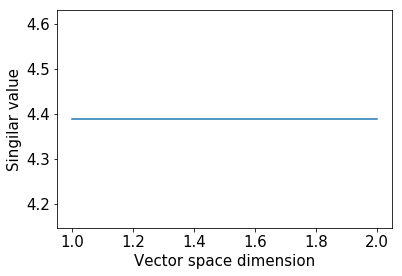

In [17]:
singular_values = pd.DataFrame(np.load(path+'svd.s.npy'),columns=['sv'])
singular_values.index = range(1,len(singular_values)+1)
print('Singular values:', \
      ', '.join(str(round(x,2)) for x in singular_values['sv']))
singular_values
plt.plot(singular_values.index, singular_values['sv'])
plt.xlabel('Vector space dimension')
plt.ylabel('Singilar value')
plt.show()

Words in vector space, axes 1 and 2


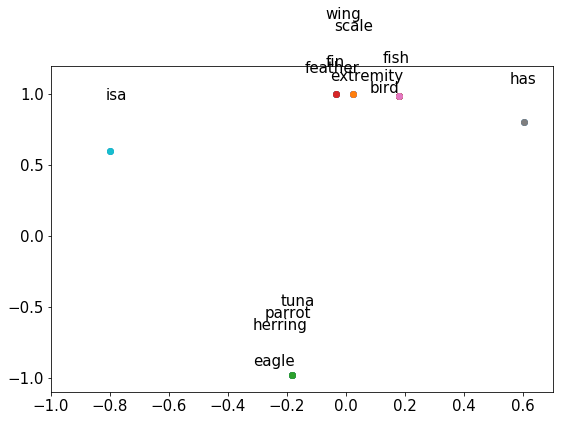

In [18]:
plot2d(1, 2, vdf, 'word', 15)

Silhouette index in a range of cluster numbers


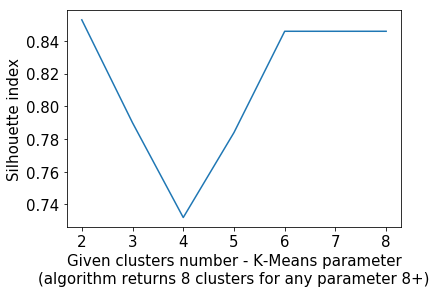

N,NR,Silhouette,Clusters
2,2,0.853,bird extremity feather fin fish has isa scale wing | eagle herring parrot tuna
3,3,0.79,bird extremity feather fin fish has scale wing | eagle herring parrot tuna | isa
4,4,0.732,bird extremity feather fin fish scale wing | eagle herring parrot tuna | isa | has
5,5,0.784,eagle herring parrot tuna | bird extremity fish | isa | has | feather fin scale wing
6,6,0.846,isa | eagle herring parrot tuna | bird extremity fish | has | fin wing | feather scale
7,6,0.846,feather scale | eagle herring parrot tuna | isa | has | bird extremity fish | fin wing
8,6,0.846,fin wing | eagle herring parrot tuna | isa | has | bird extremity fish | feather scale


In [19]:
words = vdf['word'].tolist()
df = zdf.copy()
del df['word']
sil_range = pd.DataFrame(columns=['NC','NR','Silhouette','Inertia'])
sil_range['NC'] = sil_range['NC'].astype(int)
table = [['N', 'NR', 'Silhouette', 'Clusters']]
tsv = 'N\tNR\tSilhouette\tClusers\n'
for i,j in enumerate(range(2,9)):
    silhouette, inertia, cluster_labels, centroids, cluster_sizes, \
        cluster_word_ids, cluster_words = cluster_kmeans(j, df, words)
    sil_range.loc[i] = [j, len(cluster_words), round(silhouette,3), inertia]
    table.append([j, len(cluster_words), round(silhouette,3), \
        ' | '.join(' '.join(str(word) for word in cluster)
            .replace('###LEFT-WALL###', '#LW#') for cluster in cluster_words)])
    tsv = tsv + str(j) + '\t' + str(len(cluster_words)) + '\t' + \
        str(round(silhouette,3)) + '\t' + \
        ' '.join('|'.join(str(word) for word in cluster) \
                 for cluster in cluster_words) + '\n'
sil_range[['NC','NR']] = sil_range[['NC','NR']].astype(int)

print('Silhouette index in a range of cluster numbers')
plt.plot(sil_range['NC'], sil_range['Silhouette'])
plt.xlabel('Given clusters number - K-Means parameter\n' + \
           '(algorithm returns 8 clusters for any parameter 8+)')
plt.ylabel('Silhouette index')
plt.show()
display(html_table(table))

In [20]:
n = 6  # Number of clusters
words = vdf['word'].tolist()
#-df = vdf.loc[:,[1,2,3,4,5,6,7,8]]   # defined above
silhouette, inertia, cluster_labels, centroids, cluster_sizes, \
    cluster_word_ids, cluster_words = cluster_kmeans(n, df, words)
cdf = pd.DataFrame(centroids)
def row_index(row): return int(row.name)
def cluster_word_list(row): return cluster_words[int(row.name)]
cls = cdf.applymap(zeros)
cls['cluster_words'] = cls.apply(cluster_word_list, axis=1)
cls.index = range(1,len(cls)+1)
cls['cluster'] = cls.apply(row_index, axis=1)
for col in cls.columns:
    if type(col) == int: cls=cls.rename(columns={col:col+11})
for col in cls.columns:
    if type(col) == int: cls=cls.rename(columns={col:col-10})
plot2d(1, 2, cls, 'cluster_words', 15)
cls

ValueError: could not broadcast input array from shape (4) into shape (2)

In [ ]:
sim_df, res6 = cosine_similarity(centroids, cluster_words, 'max')
count, division = np.histogram(sim_df['similarity'])
sim_df['similarity'].hist(bins=division)
print('Cluster similarities: absolute values > 0.1:')
sim_df.sort_values(by='similarity', ascending=False) \
      .loc[abs(sim_df['similarity']) > 0.1]

## Alas...
Removing ##LEFT-WALL## and period from sentences seems to help us learn a category of nouns from the clusters, **but**:  
 - verbs stay in separate categories for any similarity setting
 - negative similarity values need further research...
 
Still, the situation might dramatically improve with the dataset expansion.   
Learning on a small set of single samples sounds too good to be true :)